In [1]:
! nvidia-smi

Sun Apr 12 00:49:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.74       Driver Version: 418.74       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:02:00.0 Off |                  N/A |
| 51%   84C    P2   240W / 250W |   9750MiB / 12196MiB |     64%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   43C    P0    79W / 250W |     11MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:

from twmyle.pyutils import env_arg , set_gpu
EXP_NAME = env_arg( "EXP_NAME" , default="dae_50" )  
net_arch = env_arg("net_arch" , default="50")
gpu = env_arg("gpu" , default=2 )

set_gpu( gpu )


In [3]:
from keras.layers import *
from keras.models import *

Using TensorFlow backend.
/home/scratch/divamg/software/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scratch/divamg/software/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scratch/divamg/software/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sc

In [4]:
import keras.backend as K
import tensorflow as tf
from tensorflow.python.framework import ops


In [5]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import keras 
keras.__version__

'2.3.1'

In [7]:
eps = 0.0000001

In [8]:
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))
    
    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)

def discrete_func(x , np_fn , name=None):
    
    with ops.name_scope(name, "Mysquare", [x]) as name:
        sqr_x = py_func( np_fn ,
                        [x],
                        [tf.float32],
                        name=name,
                        grad=_identity_grad)  
        sqr_x[0].set_shape(x.shape)
        return sqr_x[0]

# Actual gradient:
def _identity_grad(op, grad):
    return grad 


def binarize_np( x ):
    a = np.zeros_like( x  )
    a[x>0.5] = 1
    return a

def onehot_np( x ):
    assert len(x.shape) == 2
    inds = x.argmax(-1)
    a = np.zeros_like( x  )
    a[ range( len(inds) ) ,inds] = 1
    return a 

def Dis_Binarize():
    return Lambda( lambda x: discrete_func(x , binarize_np )  )


def Dis_OneHot():
    return Lambda( lambda x: discrete_func(x , onehot_np )  )


In [10]:
layer_sizes = net_arch.split("_")
layer_sizes = list(map(int , layer_sizes ))

In [11]:
inp_img = Input((28,28,1))

x =  Reshape((28*28*1,))(inp_img)

for ll in layer_sizes:
    x = Dense( ll )(x )
    x = Activation('relu')(x)


before_dis = x
x = Dis_Binarize()( x )
enc_out = x 
after_dis_detach = K.stop_gradient( x )
    
commit_loss = keras.metrics.mean_squared_error( after_dis_detach , before_dis  )

# decocder
inp_hidden = Input((layer_sizes[-1],))

x = inp_hidden

for ll in layer_sizes[:-1][::-1]:
    x = Dense( ll )(x )
    x = Activation('relu')(x)

x = Dense( 28*28 )(x)


x = Activation('sigmoid')(x)
y = Reshape((28,28,1))(x)
m_dec = Model( inp_hidden , y )

m_enc = Model( inp_img , enc_out )

m = Model(input=inp_img, output=m_dec(enc_out)  )

m.add_loss((0.2/(28.0*28.0)) * commit_loss)

m.compile(loss='binary_crossentropy', optimizer='adam' )
    

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


/home/scratch/divamg/software/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


In [12]:
m.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                39250     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 50)                0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         39984     
Total params: 79,234
Trainable params: 79,234
Non-trainable params: 0
_______________________________________________________

In [13]:
m_enc.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                39250     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 50)                0         
Total params: 39,250
Trainable params: 39,250
Non-trainable params: 0
_________________________________________________________________


In [14]:
m_dec.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               39984     
_________________________________________________________________
activation_2 (Activation)    (None, 784)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
Total params: 39,984
Trainable params: 39,984
Non-trainable params: 0
_________________________________________________________________


In [15]:
def show_recon( ):
    x = x_train[:10]
    xp = m.predict(x ) ; 
    b = np.concatenate(x[:8 , : , : , 0 ] , 1)
    a = np.concatenate(xp[:8 ,: , : ,  0 ] , 1)
        
    plt.imshow(a)
    plt.show()
    plt.imshow(b)
    plt.show()

In [16]:
def show_recon( ):
    x = x_train[:10]
    codes = m_enc.predict(x ) 
    xp = m_dec.predict( codes )
    b = np.concatenate(x[:8 , : , : , 0 ] , 1)
    a = np.concatenate(xp[:8 ,: , : ,  0 ] , 1)
        
    plt.imshow(a)
    plt.show()
    plt.imshow(b)
    plt.show()

In [17]:
def save_stuff( ):
    x = x_train 
    codes = m_enc.predict(x ) 
    xp = m_dec.predict( codes )
    b = np.concatenate(x[:8 , : , : , 0 ] , 1)
    a = np.concatenate(xp[:8 ,: , : ,  0 ] , 1)
    
    np.savez( "outs/"+EXP_NAME + ".npz" , 
		original=(x*255).astype('uint8') , 
		encoded=codes.astype('uint8') , 
        decoded=(xp*255).astype('uint8')    )
    


In [18]:
from keras.datasets import mnist

In [19]:
img_rows, img_cols = 28, 28
num_classes = 10
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [20]:
# m.predict(x_train[:10])

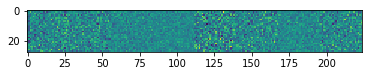

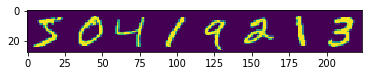

In [21]:
show_recon()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 29s 480us/step - loss: 0.3989 - val_loss: 0.5392


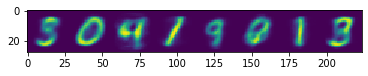

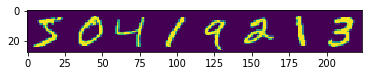

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 29s 479us/step - loss: 0.5353 - val_loss: 0.5484


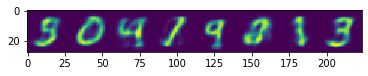

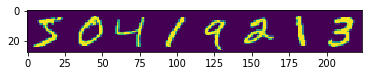

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 29s 476us/step - loss: 0.5633 - val_loss: 0.5976


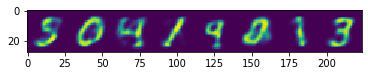

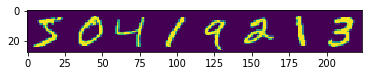

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 29s 483us/step - loss: 0.6112 - val_loss: 0.6329


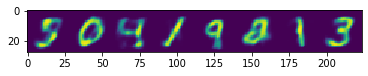

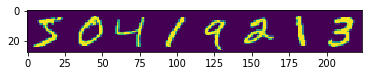

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 28s 461us/step - loss: 0.6409 - val_loss: 0.6660


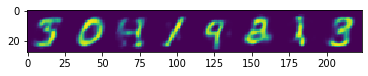

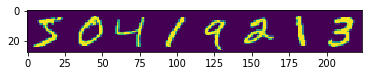

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 28s 463us/step - loss: 0.6703 - val_loss: 0.6934


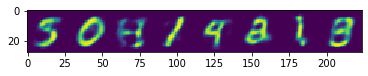

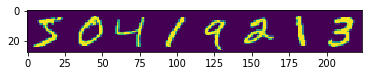

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 28s 462us/step - loss: 0.6979 - val_loss: 0.7209


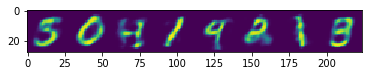

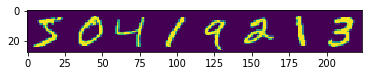

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 28s 469us/step - loss: 0.7267 - val_loss: 0.7543


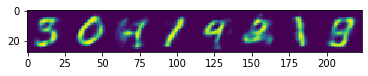

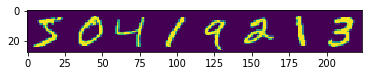

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 28s 460us/step - loss: 0.7538 - val_loss: 0.7747


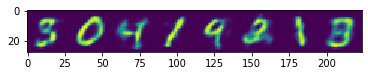

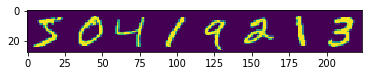

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 29s 483us/step - loss: 0.7682 - val_loss: 0.7875


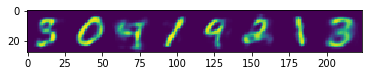

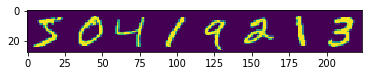

In [22]:
for ep in range(10):
    m.fit(x_train, x_train,
              batch_size=16,
              epochs=1,
              verbose=1,
              validation_data=(x_test, x_test))
    show_recon( )

In [23]:
8

8

In [24]:
save_stuff()